# Time series decomposition/forecast in R

Examples of X 13ARIMA SEATS in R  
https://github.com/christophsax/seasonal/wiki/Examples-of-X-13ARIMA-SEATS-in-R

# Import libraries

In [1]:
library(lubridate)

library(dotenv)

library(httr)
library(jsonlite)

library(ggplot2)
library(repr)

library(reshape)

library(forecast)
library(seasonal)
library(bsts)

options(repr.plot.width = 7.5, repr.plot.height = 4)


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


Attaching package: ‘reshape’

The following object is masked from ‘package:lubridate’:

    stamp

Loading required package: BoomSpikeSlab
Loading required package: Boom
Loading required package: MASS

Attaching package: ‘Boom’

The following object is masked from ‘package:stats’:

    rWishart

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: xts


# Load FRED API key

In [2]:
load_dot_env(".env")
API_KEY <- Sys.getenv("API_KEY")

# Get time series data

In [3]:
INFO_GET_FORMAT <- "https://api.stlouisfed.org/fred/series"
TIMESERIES_GET_FORMAT <- "https://api.stlouisfed.org/fred/series/observations"
SERIES_ID <- "NATURALGAS"
GET_QUERY <- list(series_id=SERIES_ID, api_key=API_KEY, file_type="json")

In [4]:
info_result <- GET(INFO_GET_FORMAT, query=GET_QUERY)

In [5]:
info_result_text <- content(info_result, "text")
info_result_json <- fromJSON(info_result_text, flatten=TRUE)
series_title <- info_result_json$series$title
sereis_unit <- info_result_json$series$units
info_result_json$series

id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
NATURALGAS,2018-09-11,2018-09-11,Natural Gas Consumption,2000-01-01,2018-06-01,Monthly,M,Billion Cubic Feet,Bil. Cubic Feet,Not Seasonally Adjusted,NSA,2018-08-20 09:51:02-05,24,This data is collected by the U.S. Energy Information Administration (EIA) available at: http://www.eia.gov/dnav/ng/hist/n9140us2m.htm and http://www.eia.doe.gov/emeu/steo/pub/contents.html (forecast).


In [6]:
timeseries_result <- GET(TIMESERIES_GET_FORMAT, query=GET_QUERY)

In [7]:
timeseries_result_text <- content(timeseries_result, "text")
timeseries_result_json <- fromJSON(timeseries_result_text, flatten=TRUE)
data_df <- as.data.frame(timeseries_result_json$observations)[, c("date", "value")]
data_df$date <- as.Date(data_df$date)
data_df$value <- as.numeric(data_df$value)

In [8]:
data_df

date,value
2000-01-01,2510.5
2000-02-01,2330.7
2000-03-01,2050.6
2000-04-01,1783.3
2000-05-01,1632.9
2000-06-01,1513.1
2000-07-01,1525.6
2000-08-01,1653.1
2000-09-01,1475.0
2000-10-01,1567.8


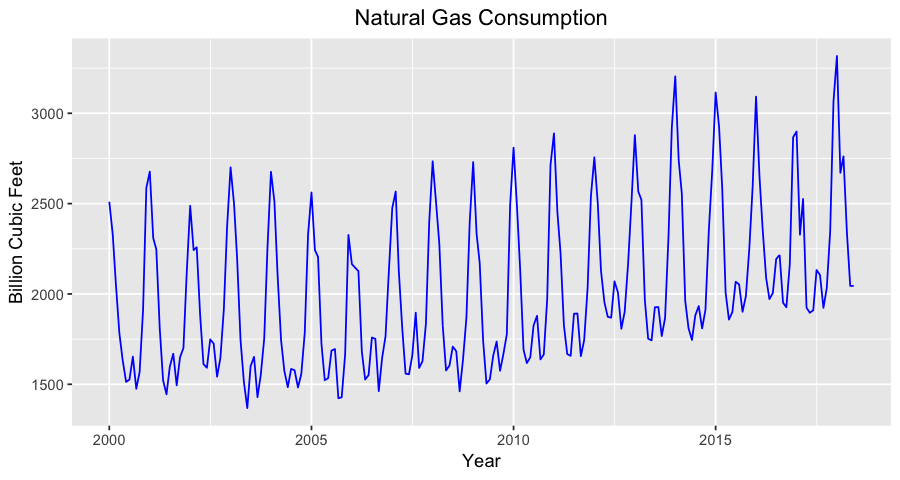

In [9]:
ggplot(data=data_df, aes(x=date)) +
    geom_line(aes(y=value), colour='blue') +
    xlab('Year') + ylab(sereis_unit) +
    ggtitle(series_title) + 
    theme(plot.title=element_text(hjust=0.5))

In [10]:
start_date <- data_df$date[1]
ts_data_df <- ts(data_df$value, start=c(year(start_date), month(start_date)), frequency=12)

# Package "seas"

## X11 decomposition
X11 decomposition  
https://otexts.org/fpp2/x11.html

In [11]:
x11_fit <- seas(ts_data_df, x11='')

### X11 five best ARIMA models

In [12]:
fivebestmdl(x11_fit)

arima,bic
(2 0 1)(0 1 1),-3.084
(1 0 2)(0 1 1),-3.075
(2 0 2)(0 1 1),-3.062
(1 0 1)(0 1 1),-3.025
(1 0 0)(0 1 1),-3.019


### X11 decomposition

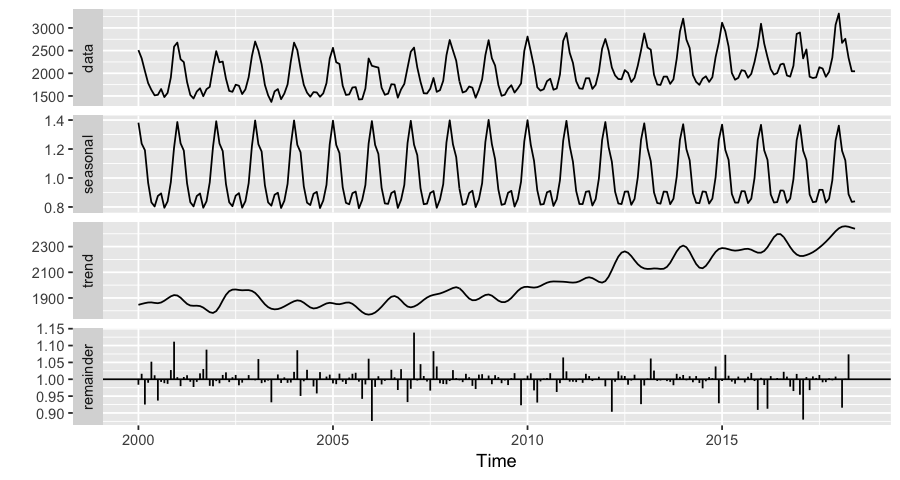

In [13]:
autoplot(x11_fit)

Import X-13ARIMA-SEATS Output Tables  
https://www.rdocumentation.org/packages/seasonal/versions/1.6.1/topics/series

specs have been added to the model: forecast


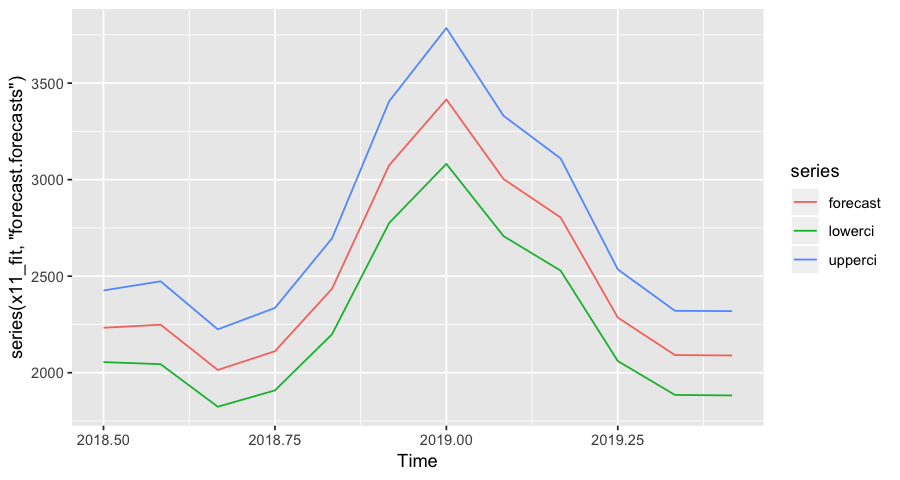

In [14]:
autoplot(series(x11_fit, "forecast.forecasts"))

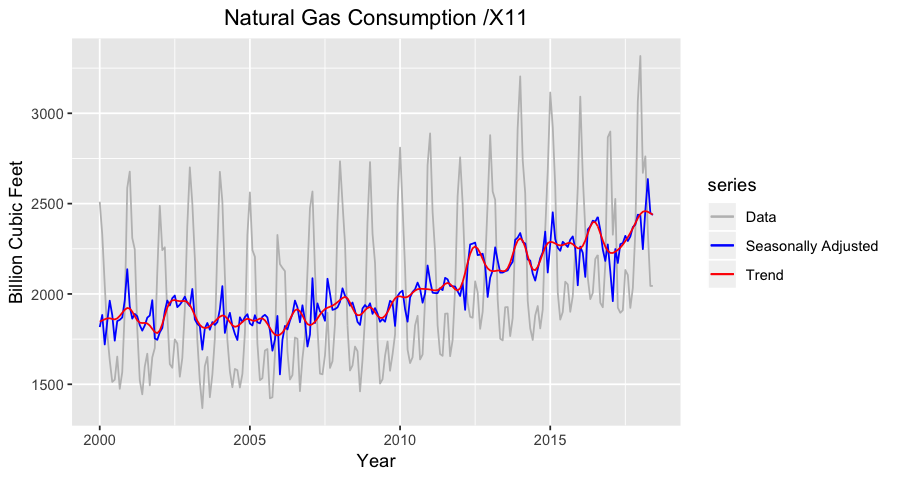

In [15]:
autoplot(ts_data_df, series="Data") +
    autolayer(seasadj(x11_fit), series="Seasonally Adjusted") +
    autolayer(trend(x11_fit), series="Trend") +
    ggtitle(paste(series_title, "/X11")) +
    xlab("Year") + ylab(sereis_unit) +
    scale_colour_manual(values=c("gray", "blue", "red")) +
    theme(plot.title=element_text(hjust=0.5))


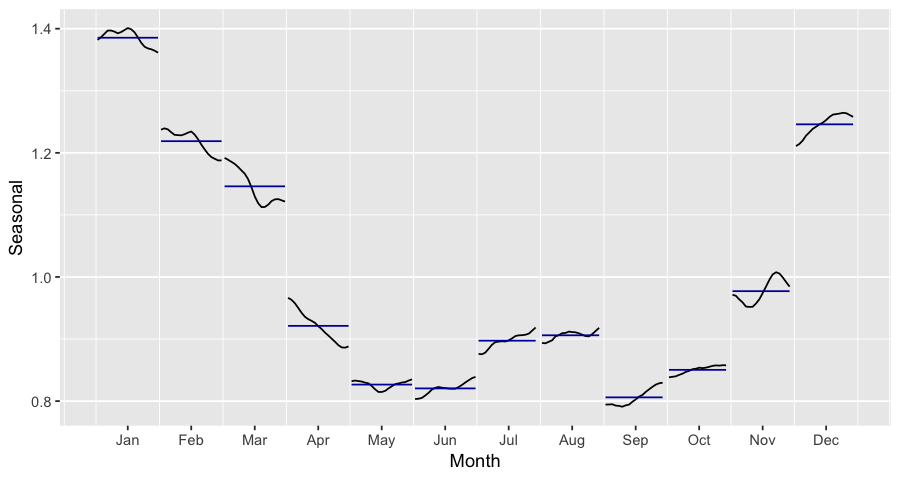

In [16]:
x11_fit %>% seasonal() %>% ggsubseriesplot() + ylab("Seasonal")

## SEATS decomposition

SEATS decomposition  
https://otexts.org/fpp2/seats.html

In [17]:
seats_fit <- seas(ts_data_df)

### SESTS five best ARIMA models

In [18]:
fivebestmdl(seats_fit)

arima,bic
(2 0 1)(0 1 1),-3.084
(1 0 2)(0 1 1),-3.075
(2 0 2)(0 1 1),-3.062
(1 0 1)(0 1 1),-3.025
(1 0 0)(0 1 1),-3.019


### SEATS decomposition

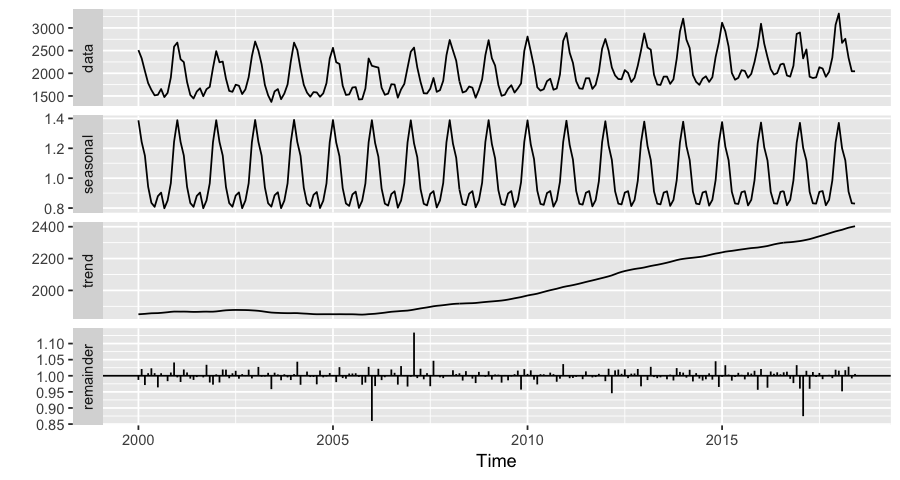

In [19]:
autoplot(seats_fit)

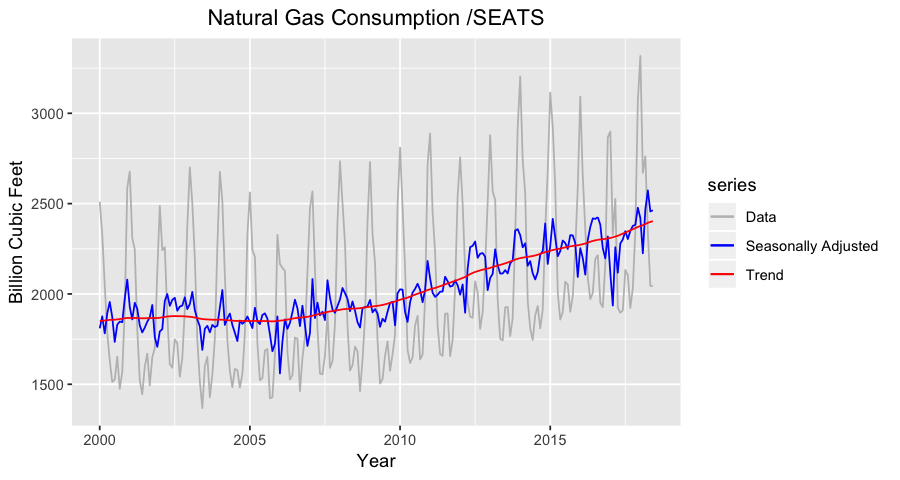

In [20]:
autoplot(ts_data_df, series="Data") +
    autolayer(seasadj(seats_fit), series="Seasonally Adjusted") +
    autolayer(trend(seats_fit), series="Trend") +
    ggtitle(paste(series_title, "/SEATS")) +
    xlab("Year") + ylab(sereis_unit) +
    scale_colour_manual(values=c("gray", "blue", "red")) +
    theme(plot.title=element_text(hjust=0.5))

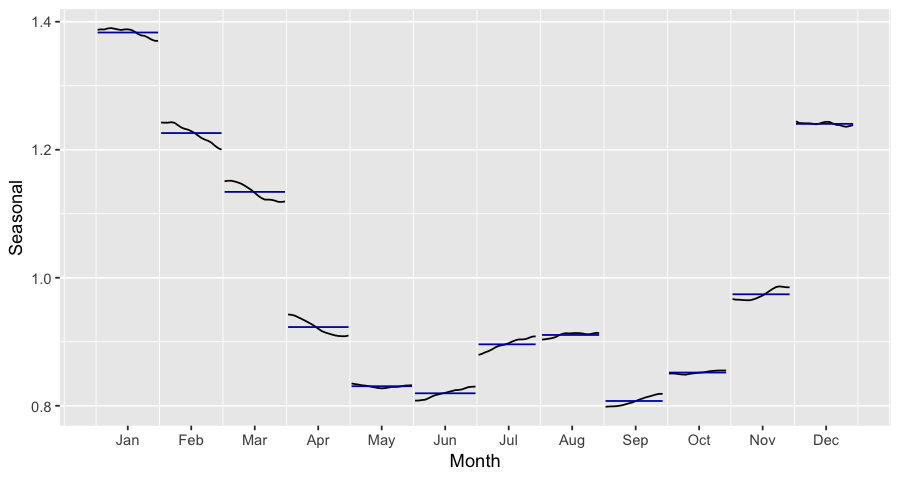

In [21]:
seats_fit %>% seasonal() %>% ggsubseriesplot() + ylab("Seasonal")

# Package "bsts"
## Bayesian structural time series model

Bayesian Structural Time Series  
https://www.rdocumentation.org/packages/bsts/versions/0.8.0/topics/bsts  
Sorry ARIMA, but I’m Going Bayesian  
https://multithreaded.stitchfix.com/blog/2016/04/21/forget-arima/  
A quick intro to bsts  
https://rstudio-pubs-static.s3.amazonaws.com/257314_131e2c97e7e249448ca32e555c9247c6.html

In [22]:
log_y <- log(ts_data_df)

add.local.linear.trend  
https://www.rdocumentation.org/packages/bsts/versions/0.8.0/topics/add.local.linear.trend  
add.seasonal  
https://www.rdocumentation.org/packages/bsts/versions/0.8.0/topics/add.seasonal



In [23]:
## bsts model
bsts_ss <- AddLocalLinearTrend(list(), log_y)
bsts_ss <- AddSeasonal(bsts_ss, log_y, nseasons=12)
bsts.model <- bsts(log_y, state.specification = bsts_ss, niter = 500, ping=0)

### decomposition

In [24]:
burn <- SuggestBurn(0.1, bsts.model)

In [25]:
# extract the components
components <- cbind.data.frame(
    data=data_df$value,
    seasonal=colMeans(exp(bsts.model$state.contributions[-(1:burn),"seasonal.12.1",])),
    trend=colMeans(exp(bsts.model$state.contributions[-(1:burn),"trend",])),                               
    as.Date(time(log_y)))
components$remainder <- components$data / components$seasonal / components$trend
names(components) <- c('data', 'seasonal', 'trend', 'date', 'remainder')
components <- melt(components, id="date")
names(components) <- c("date", "component", "value")

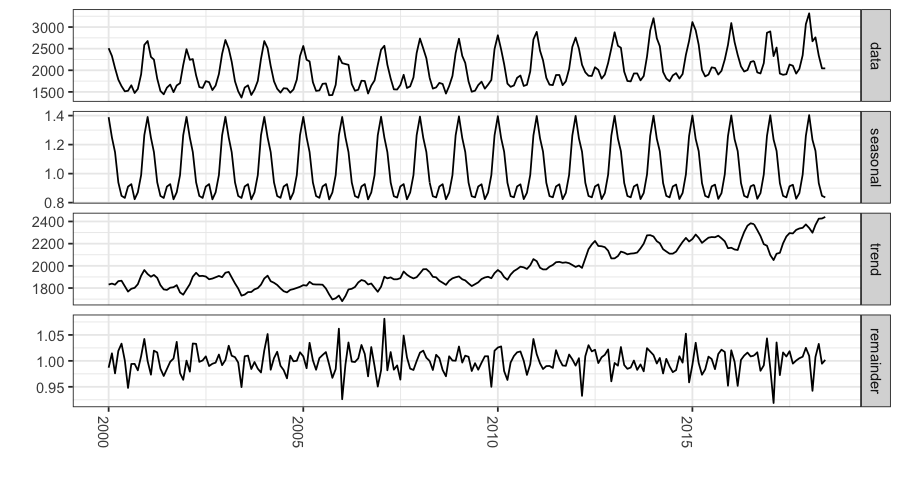

In [26]:
ggplot(data=components, aes(x=date, y=value)) +
    geom_line() + 
    theme_bw() + 
    theme(legend.title = element_blank()) + 
    ylab("") + xlab("") + 
    facet_grid(component ~ ., scales="free") + guides(colour=FALSE) + 
    theme(axis.text.x=element_text(angle = -90, hjust = 0))

### Prediction
Prediction For Bayesian Structural Time Series  
https://www.rdocumentation.org/packages/bsts/versions/0.8.0/topics/predict.bsts

In [27]:
bsts_predict <- predict.bsts(bsts.model, horizon=12, burn=burn, quantiles=c(.025, .975))

In [54]:
# actual vs predicted
bsts_predict

$mean
 [1] 7.705120 7.730565 7.613387 7.663978 7.817046 8.050973 8.148961 8.023681
 [9] 7.951620 7.750973 7.649460 7.628098

$median
 [1] 7.701559 7.731835 7.612818 7.667707 7.828828 8.047399 8.135834 8.030809
 [9] 7.947957 7.756496 7.644101 7.634703

$interval
          [,1]     [,2]     [,3]     [,4]     [,5]     [,6]     [,7]     [,8]
2.5%  7.617262 7.632296 7.522234 7.574809 7.683692 7.939990 8.044976 7.897637
97.5% 7.791456 7.809028 7.703756 7.757410 7.926518 8.157635 8.285587 8.133733
          [,9]    [,10]    [,11]    [,12]
2.5%  7.852676 7.623549 7.535691 7.479604
97.5% 8.059197 7.845866 7.762615 7.766454

$distribution
          [,1]     [,2]     [,3]     [,4]     [,5]     [,6]     [,7]     [,8]
 [1,] 7.758598 7.782477 7.654691 7.715910 7.943422 8.152066 8.236006 8.059006
 [2,] 7.688595 7.755806 7.573701 7.608986 7.705016 8.053318 8.113980 7.992470
 [3,] 7.672471 7.645468 7.557259 7.646318 7.873579 7.978791 8.108579 7.960397
 [4,] 7.623593 7.761237 7.562149 7.677127 7.741272 